Memory usage:
https://stackoverflow.com/questions/39890147/keras-uses-way-too-much-gpu-memory-when-calling-train-on-batch-fit-etc

https://medium.com/@julsimon/keras-shoot-out-part-2-a-deeper-look-at-memory-usage-8a2dd997de81

# Train VOLVuLuS incl. data augmentation

## Set seeds and import packages

In [24]:
RANDOM_STATE = 42
from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

import VOLVuLuS_settings as settings

from dltoolkit.utils.generic import model_architecture_to_file, model_summary_to_file, list_images
from dltoolkit.nn.segment import UNet_3D_NN
from dltoolkit.utils.visual import plot_training_history, plot_roc_curve, plot_precision_recall_curve,\
    print_confusion_matrix, print_classification_report
from dltoolkit.iomisc import HDF5Generator_Segment

from thesis_common import convert_img_to_pred_3D, convert_pred_to_img_3D, create_hdf5_db_3D,\
    show_image, read_preprocess_image, read_preprocess_groundtruth, print_training_info
from thesis_metric_loss import dice_coef, weighted_pixelwise_crossentropy_loss

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
import os, cv2, time, progressbar

import matplotlib.pyplot as plt
%matplotlib inline

## Convert training set to HDF5

In [2]:
def perform_hdf5_conversion_3D(settings):
    """Convert the training and test images, ground truths and masks to HDF5 format. The assumption is that images
    are all places in the same folder, regardless of the patient.
    """
    output_paths = []

    print("training images")
    # Convert training images in each sub folder to a single HDF5 file
    output_paths.append(create_hdf5_db_3D(os.path.join(settings.TRAINING_PATH, settings.FLDR_IMAGES),
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        img_exts=".jpg", key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                        settings=settings))

    print("training ground truths")
    # Training ground truths
    output_paths.append(create_hdf5_db_3D(os.path.join(settings.TRAINING_PATH, settings.FLDR_GROUND_TRUTH),
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        img_exts=".jpg", key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                        settings=settings, is_mask=True))

    # Do the same for the test images
    print("test images")
    output_paths.append(create_hdf5_db_3D(os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES),
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        img_exts=".jpg", key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                        settings=settings))

    return output_paths

## Enable/disable cross-validation

In [3]:
USE_KFOLD_CV = False

In [4]:
# Convert image files to HDF5
if settings.IS_DEVELOPMENT:
    print("\n--- Converting images to HDF5")
    hdf5_paths = perform_hdf5_conversion_3D(settings)
    
    if settings.TRN_TRAIN_VAL_SPLIT == 0:
        print("Not creating a validation set")
    else:
        print("Creating a {} training/validation set".format(settings.TRN_TRAIN_VAL_SPLIT))
else:
    # During development avoid performing HDF5 conversion for every run
        hdf5_paths = ["../data/MSC8002/training_3d/images.h5",
                      "../data/MSC8002/training_3d/groundtruths.h5",
                      ]

Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00



--- Converting images to HDF5
training images
training ground truths
test images
Not creating a validation set


## Class distribution

In [5]:
# Print class distribution
class_weights = [settings.CLASS_WEIGHT_BACKGROUND, settings.CLASS_WEIGHT_BLOODVESSEL]
print("Class distribution: {}".format(class_weights))

Class distribution: [1.0, 10.0]


## Create the 3D U-Net model

In [6]:
unet = UNet_3D_NN(img_height=settings.IMG_HEIGHT,
                  img_width=settings.IMG_WIDTH,
                  num_slices=settings.SLICE_END - settings.SLICE_START,
                  img_channels=settings.IMG_CHANNELS,
                  num_classes=settings.NUM_CLASSES)
# model = unet.build_model()
model = unet.build_model_3lyr()

conv_contr1: (?, 240, 240, 8, 32)
conv_contr1: (?, 240, 240, 8, 64)
pool_contr1: (?, 120, 120, 4, 64)
conv_bottom I: (?, 120, 120, 4, 64)
conv_bottom II: (?, 120, 120, 4, 128)
scale_up1: (?, 240, 240, 8, 128)
merge_up1: (?, 240, 240, 8, 192)
conv_up1 I: (?, 240, 240, 8, 64)
conv_up1 II: (?, 240, 240, 8, 64)
final: (?, 240, 240, 8, 2)


## Create paths

In [7]:
# Prepare some path strings
model_path = os.path.join(settings.MODEL_PATH, "VOLVuLuS_" + unet.title + "_ep{}.model".format(settings.TRN_NUM_EPOCH))
summ_path = os.path.join(settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title + "_model_summary.txt")
csv_path = os.path.join(settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title + "_training_ep{}_bs{}.csv".format(settings.TRN_NUM_EPOCH,
                                                                                            settings.TRN_BATCH_SIZE))

## Save/print model architecture information

In [8]:
model.summary()
model_summary_to_file(model, summ_path)
model_architecture_to_file(unet.model, settings.OUTPUT_PATH + "VOLVuLuS_" + unet.title)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 8,  0                                            
__________________________________________________________________________________________________
contr1_1 (Conv3D)               (None, 240, 240, 8,  896         input_1[0][0]                    
__________________________________________________________________________________________________
contr1_2 (Conv3D)               (None, 240, 240, 8,  55360       contr1_1[0][0]                   
__________________________________________________________________________________________________
contr1_mp (MaxPooling3D)        (None, 120, 120, 4,  0           contr1_2[0][0]                   
__________________________________________________________________________________________________
bottom1 (C

## Compile the model

In [9]:
# Set the optimiser, loss function and metrics
opt = Adam()
metrics = [dice_coef]
loss = weighted_pixelwise_crossentropy_loss(class_weights)

# Compile
model.compile(optimizer=opt, loss=loss, metrics=metrics)

## Load data

### Option 1: Use generators

### Option 2: Load all data into memory

In [10]:
train_imgs = read_preprocess_image(hdf5_paths[0], settings.HDF5_KEY, is_3D=True)
train_grndtr = read_preprocess_groundtruth(hdf5_paths[1], settings.HDF5_KEY, is_3D=True)
train_grndtr_ext_conv = convert_img_to_pred_3D(train_grndtr, settings.NUM_CLASSES, settings.VERBOSE)

print("Number of samples: {}".format(len(train_imgs)))

Loading image HDF5: ../data/MSC8002/training_3d/images.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training_3d/groundtruths.h5 with dtype = uint8

Elapsed time: 0.008790969848632812


## Train the model

### Train WITH a validation set - ALL IN MEMORY

### Train WITHOUT a validation set - ALL IN MEMORY

In [12]:
if not USE_KFOLD_CV:
    print("Training with just a training set, no validation set used.")
    print_training_info(unet, model_path, train_imgs.shape, settings, opt, loss)
    print("Training start:\n")
    
    # Prepare callbacks
    callbacks = [
        ModelCheckpoint(model_path, monitor="loss", mode="min", save_best_only=True, verbose=1),
        EarlyStopping(monitor='loss', min_delta=0, patience=settings.TRN_EARLY_PATIENCE, verbose=0, mode="auto"),
        CSVLogger(csv_path, append=False),
        ]

    # Fit the model using a training set only
    start_time = time.time()
    hist = model.fit(train_imgs, train_grndtr_ext_conv,
                     epochs=settings.TRN_NUM_EPOCH,
                     batch_size=settings.TRN_BATCH_SIZE,
                     verbose=2,
                     shuffle=True,
                     callbacks=callbacks)

    print("\n\nElapsed training time: {} min".format(int((time.time() - start_time))/60))
else:
    print("Cross-validation selected, not performing one-off training with just a training set")

Training with just a training set, no validation set used.
              Model: UNet3D_brain_2layer_no_BN
          Saving to: ../savedmodels/VOLVuLuS_UNet3D_brain_2layer_no_BN_ep200.model
        Input shape: (1, 240, 240, 8, 1)
Settings:
         IMG_HEIGHT: 240
          IMG_WIDTH: 240
       IMG_CHANNELS: 1
        NUM_CLASSES: 2
        SLICE_START: 55
          SLICE_END: 63
    IMG_CROP_HEIGHT: 40
     IMG_CROP_WIDTH: 40
     TRN_BATCH_SIZE: 1
  TRN_LEARNING_RATE: 0.001
      TRN_NUM_EPOCH: 200
TRN_TRAIN_VAL_SPLIT: 0.0
   TRN_DROPOUT_RATE: 0.0
       TRN_MOMENTUM: 0.99
 TRN_PRED_THRESHOLD: 0.5
 TRN_EARLY_PATIENCE: 10
Training start:

Epoch 1/200
 - 28s - loss: 330788.2812 - dice_coef: 0.5028

Epoch 00001: loss improved from inf to 330788.28125, saving model to ../savedmodels/VOLVuLuS_UNet3D_brain_2layer_no_BN_ep200.model
Epoch 2/200
 - 32s - loss: 162669.5000 - dice_coef: 0.7735

Epoch 00002: loss improved from 330788.28125 to 162669.50000, saving model to ../savedmodels/VOLVuLu

 - 28s - loss: 60149.6133 - dice_coef: 0.9401

Epoch 00048: loss did not improve
Epoch 49/200
 - 28s - loss: 61393.2031 - dice_coef: 0.9854

Epoch 00049: loss did not improve
Epoch 50/200
 - 28s - loss: 50586.1680 - dice_coef: 0.9668

Epoch 00050: loss improved from 58144.85156 to 50586.16797, saving model to ../savedmodels/VOLVuLuS_UNet3D_brain_2layer_no_BN_ep200.model
Epoch 51/200
 - 28s - loss: 55926.3516 - dice_coef: 0.9413

Epoch 00051: loss did not improve
Epoch 52/200
 - 28s - loss: 50903.1055 - dice_coef: 0.9829

Epoch 00052: loss did not improve
Epoch 53/200
 - 28s - loss: 48709.3750 - dice_coef: 0.9825

Epoch 00053: loss improved from 50586.16797 to 48709.37500, saving model to ../savedmodels/VOLVuLuS_UNet3D_brain_2layer_no_BN_ep200.model
Epoch 54/200
 - 30s - loss: 48587.0703 - dice_coef: 0.9534

Epoch 00054: loss improved from 48709.37500 to 48587.07031, saving model to ../savedmodels/VOLVuLuS_UNet3D_brain_2layer_no_BN_ep200.model
Epoch 55/200
 - 30s - loss: 44157.8672 - di

## Plot the results

KeyError: 'val_loss'

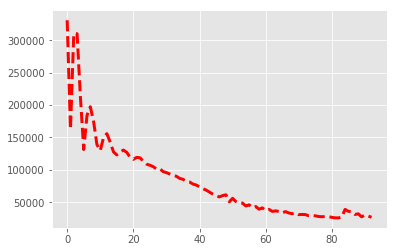

In [22]:
if not USE_KFOLD_CV:
    plot_training_history(hist,
                          settings.TRN_NUM_EPOCH,
                          show=False,
                          save_path=settings.OUTPUT_PATH + unet.title,
                          time_stamp=True,
                          metric="dice_coef")
else:
    print("Using cross-validation, no training history saved")

## Perform pipeline test

Loading image HDF5: ../data/MSC8002/training_3d/images.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training_3d/groundtruths.h5 with dtype = uint8

Elapsed time: 0.045950889587402344


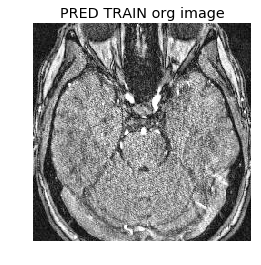

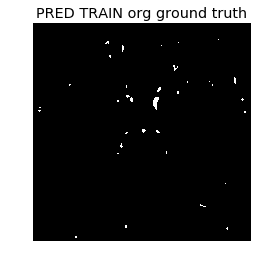

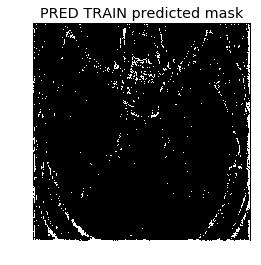

  original 1.0 dtype float32
  gr truth 255 dtype uint8
prediction 255 dtype float32


In [23]:
# Read images and ground truths
train_imgs = read_preprocess_image(hdf5_paths[0], settings.HDF5_KEY, is_3D=True)
train_grndtr = read_preprocess_groundtruth(hdf5_paths[1], settings.HDF5_KEY, is_3D=True)

# For pipeline testing only
predictions = model.predict(train_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)

# Transpose images and ground truths to the correct oder
train_imgs = np.transpose(train_imgs, axes=(0, 3, 1, 2, 4))
train_grndtr = np.transpose(train_grndtr, axes=(0, 3, 1, 2, 4))

# predictions = predictions
predictions_imgs = convert_pred_to_img_3D(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       verbose=settings.VERBOSE)

show_image(np.squeeze(train_imgs[0, 0]), 'PRED TRAIN org image')
show_image(np.squeeze(train_grndtr[0, 0]), 'PRED TRAIN org ground truth')
show_image(np.squeeze(predictions_imgs[0, 0]), 'PRED TRAIN predicted mask')

print("  original {} dtype {}".format(np.max(train_imgs[0,0]), train_imgs[0,0].dtype))
print("  gr truth {} dtype {}".format(np.max(train_grndtr[0,0]), train_grndtr[0,0].dtype))
print("prediction {} dtype {}".format(np.max(predictions_imgs[0,0]), predictions[0,0].dtype))